# MessiAhh: предсказание исходов футбольных матчей
## Подготовили: Аникин Д. А., Насонов А. О.
## Руководитель: Поповкин А.В. 

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from collections import Counter
from collections import deque
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from IPython.display import Image

%matplotlib inline

In [2]:
tour = pd.read_csv('WorldCupMatches.csv')
players = pd.read_csv('WorldCupPlayers.csv')

In [3]:
tour.head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


In [4]:
players.head()

,RoundID,MatchID,Team Initials,Coach Name,Line-up,Shirt Number,Player Name,Position,Event
0,201,1096,FRA,CAUDRON Raoul (FRA),S,0,Alex THEPOT,GK,NaN
1,201,1096,MEX,LUQUE Juan (MEX),S,0,Oscar BONFIGLIO,GK,NaN
2,201,1096,FRA,CAUDRON Raoul (FRA),S,0,Marcel LANGILLER,NaN,G40'
3,201,1096,MEX,LUQUE Juan (MEX),S,0,Juan CARRENO,NaN,G70'
4,201,1096,FRA,CAUDRON Raoul (FRA),S,0,Ernest LIBERATI,NaN,NaN


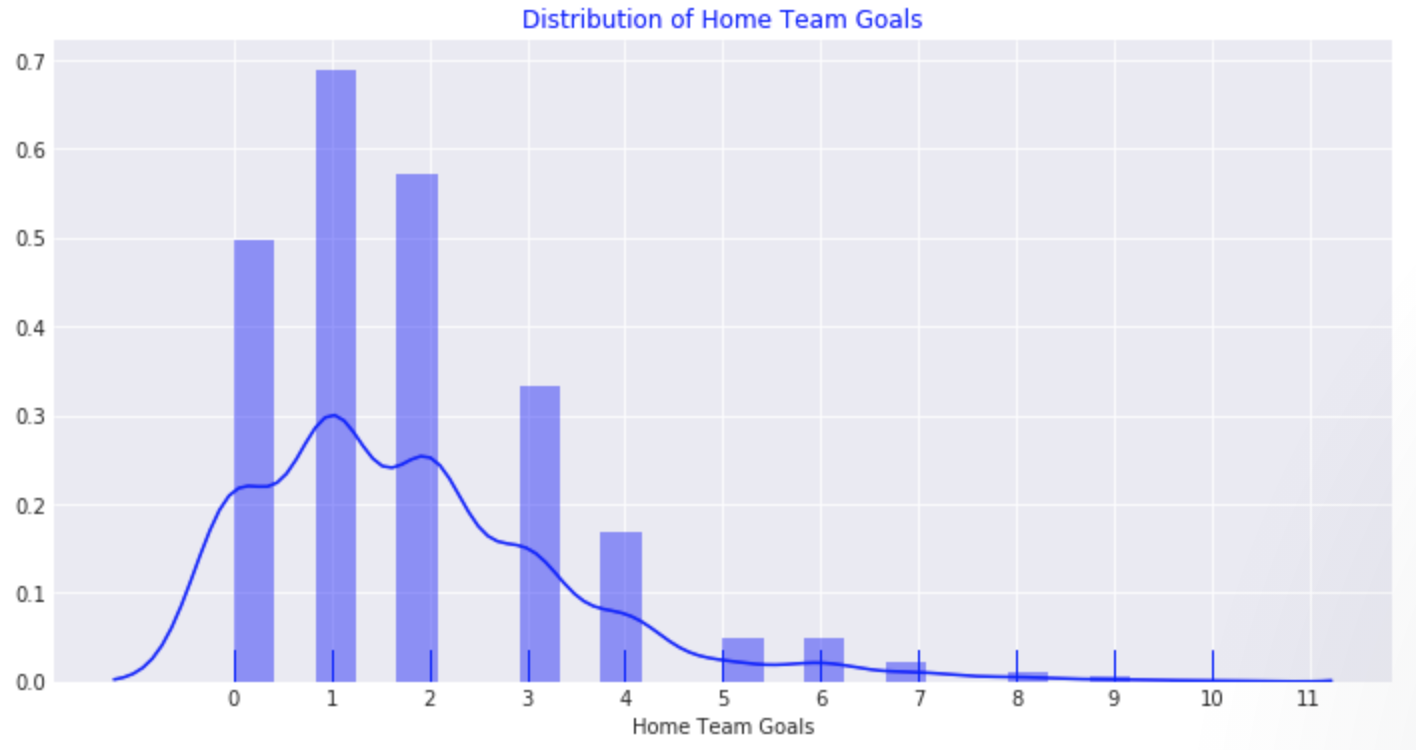

In [5]:
Image(filename='pic3.png', width=550)

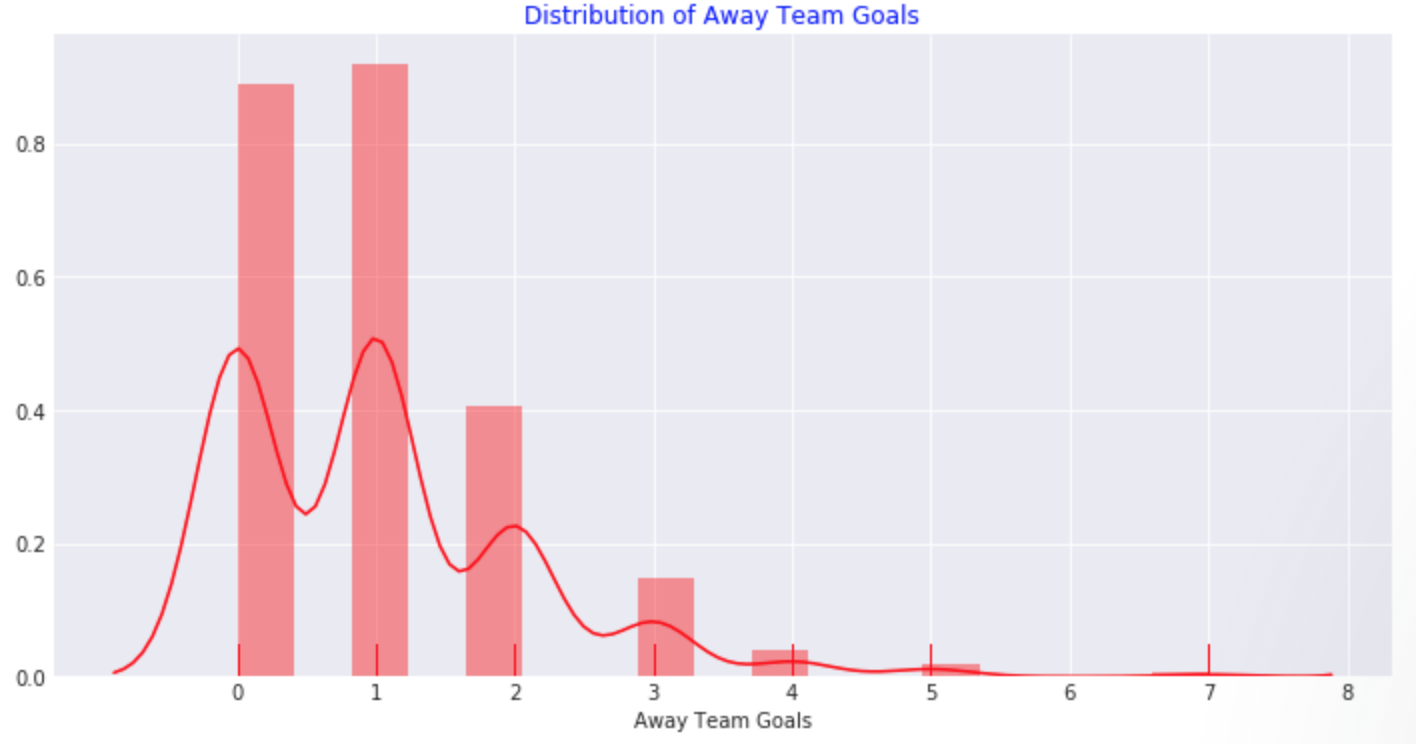

In [6]:
Image(filename='pic4.png', width=550)

In [7]:
def win(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

tour['Winner'] = tour['Home Team Goals'] - tour['Away Team Goals']
tour['Winner'] = tour['Winner'].apply(win)

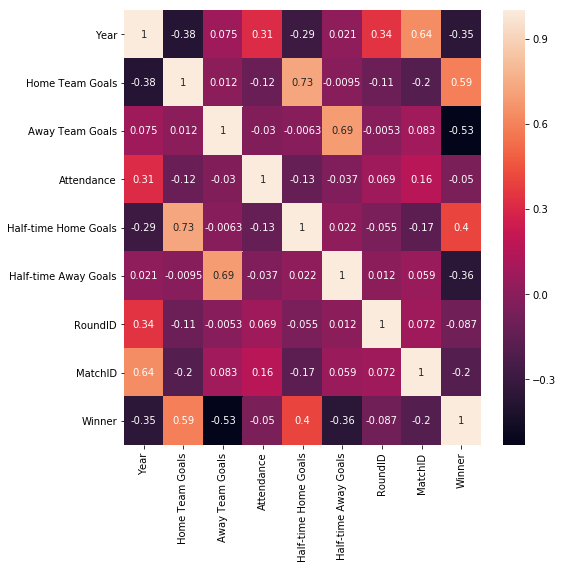

In [8]:
plt.figure(figsize=(8, 8))
sns.heatmap(tour.corr(), annot=True)

In [9]:
def parser(x):
    tmp = x.split(' ')
    
    tmp = [i for word in tmp for i in word.split('.')]
            
    lens = [len(i) for i in tmp]
    m = max(lens)
    idx = lens.index(m)
    return tmp[idx].strip('.,)(').lower()

players['Player Name'] = players['Player Name'].apply(parser)
fix_names = sorted(list(set([name for name in players['Player Name'].values if '�' in name])))

In [10]:
correct_names = {'acu�a' : 'acuña', 'akw�' : 'akwá', 'allb�ck' : 'allbäck', 'alvb�ge' : 'alvbåge', 'ar�nguiz' : 'aránguiz', 'be�i?' : 'bešić', 'bj�rnebye' : 'bjørnebye', 'bola�os' : 'bolaño', 'b�rki' : 'bürki', 'caba�as' : 'cabañas', 'casta�eda' : 'castañeda', 'ca�iza' : 'caniza', 'ca�izares' : 'cañizares', 'coentr�o' : 'coentrão', 'c�ceres' : 'cáceres', 'd�eko' : 'džeko', 'd�ini?' : 'džinić', 'etam�' : 'etamé', 'etxeberr�a' : 'etxeberria', 'fl�vio' : 'flávio', 'f�bregas' : 'fàbregas', 'gon�alves' : 'gonçalves', 'grod�s' : 'grodås', 'gro�kreutz' : 'großkreutz', 'gr�nkj�r' : 'grønkjær', 'guti�rrez' : 'gutiérrez', 'g�tze' : 'götze', 'had�i?' : 'hadžić', 'h�wedes' : 'höwedes', 'ibi�evi?' : 'ibišević', 'josu�' : 'josué', 'j�' : 'jô', 'j�rgensen' : 'jørgensen', 'kak�' : 'kaká', 'kie�ling' : 'kießling', 'kj�r' : 'kjær', 'kola�inac' : 'kolašinac', 'kr�ldrup' : 'krøldrup', 'k�llstr�m' : 'källström', 'k�pke' : 'köpke', 'lam�' : 'lamá', 'loc�' : 'locó', 'luis�o' : 'luisão', 'l�cio' : 'lúcio', 'mahouv�' : 'mahouvé', 'mand�uki?' : 'mandžukić', 'mart�nez' : 'martínez', 'matav�' : 'matavž', 'matth�us' : 'matthäus', 'milija�' : 'milijaš', 'mu�oz' : 'muñoz', 'm�ller' : 'müller', 'm�rio' : 'mário', 'nu�ez' : 'nuñez', 'olemb�' : 'olembé', 'pens�e' : 'pensée', 'peri�i?' : 'perišić', 'pe�a' : 'peña', 'piqu�' : 'piqué', 'rom�rio' : 'romário', 'sch�r' : 'schär', 'sch�rrle' : 'schürrle', 'sim�o' : 'simão', 'solskj�r' : 'solskjær', 'suba�i?' : 'subašić', 's�nchez' : 'sánchez', 's�rensen' : 'sørensen', 'to�i?' : 'tošić', 'uma�a' : 'umaña', 'ure�a' : 'ureña', 'ver�n' : 'verón', 'vi�?a' : 'višća', 'vranje�' : 'vranješ', 'vr�ajevi?' : 'vršajević', 'wom�' : 'womé', 'w�lfli' : 'wölfli', 'w�rns' : 'wörns', 'zuberb�hler' : 'zuberbühler', 'zu�iga' : 'zuñiga', '�der' : 'eder', '�eliga' : 'seliga', '�igi?' : 'zigić', '�stenstad' : 'ostenstad', '�uler' : 'suler', '�unji?' : 'sunjić', '�zil' : 'özil', 'stankovi?' : 'stanković', 'petrovi?' : 'petrović', 'ili?' : 'ilić', 'kova?i?' : 'kovačić', 'pe?nik' : 'pečnik', 'spahi?' : 'spahić', 'kuzmanovi?' : ' kuzmanović', 'mavri?' : 'mavrič', 'joki?' : 'jokić', 'ivanovi?' : 'ivanović', 'misimovi?' : 'misimović', 'oli?' : 'olić', 'salihovi?' : 'salihović', 'rakiti?' : 'rakitić', 'stevanovi?' : 'stevanović', 'krasi?' : 'krasić', 'avduki?' : 'avdukić', 'pjani?' : 'pjanić', 'fejzi?' : 'fejzić', 'dedi?' : 'dedić', 'jovanovi?' : 'jovanović', 'brozovi?' : 'brozović', 'hajrovi?' : 'hajrović', 'ka?ar' : 'kačar', 'obradovi?' : 'obradović', '?uri?i?' : 'duričić ', 'ninkovi?' : 'ninković', 'isailovi?' : 'isailović', 'vukojevi?' : 'vukojević', 'ljubijanki?' : 'ljubijankić', 'bi?ak?i?' : 'bičakčić', 'lukovi?' : 'luković', 'radosavljevi?' : 'radosavljevič', 'rebi?' : 'rebić', 'handanovi?' : 'handanovič', 'ibri?i?' : 'ibričić', 'lazovi?' : 'lazović', 'bre?ko' : 'brečko', 'suboti?' : 'subotić', 'jelavi?' : 'jelavić', 'modri?' : 'modrić', 'su�i?' : 'sušić', 'panteli?' : 'pantelić', 'novakovi?' : 'novaković', 'pranji?' : 'pranjić', 'luli?' : 'lulić', 'begovi?' : 'begović', 'filekovi?' : 'fileković', 'vidi?' : 'vidić', 'stojkovi?' : 'stojković', 'bola�o' : 'bolaño', 'h�ssler' : 'hässler', 'mujd�a' : 'mujdža'}

In [11]:
other_names = {}
for i in players['Player Name'].values:
    other_names[i] = i
other_names.update(correct_names)
players['Player Name'] = players['Player Name'].map(other_names)

In [12]:
players['Player Name'][:5]

0       thepot
1    bonfiglio
2    langiller
3      carreno
4     liberati
Name: Player Name, dtype: object

Создание json файла с составами команд

In [13]:
d = {}

for i in players.groupby(['MatchID', 'Team Initials']):
    team = i[0][1]
    name = i[1]['Player Name']
    match = i[0][0]
    year = tour[tour['MatchID'] == match]['Year']
    res = tour[tour['MatchID'] == match]['Winner']
    kek = (match, name.values, year.values[0], res.values[0])
    if team in d:
        d[team].append(kek)
    else:
        d[team] = deque(maxlen=3)
        d[team].append(kek)

In [14]:
js = {}

for k, v in d.items():
    js[k] = sorted(list(set([names for tpl in v for names in tpl[1]])))

with open('players.json', 'w') as f:
    json.dump(js, f)

In [15]:
# js

In [16]:
cv = CountVectorizer()
cv_fit = cv.fit_transform(players['Player Name'])
players['Player Name'] = players['Player Name'].apply(cv.vocabulary_.get)
n = players['Player Name'].max() + 1200
players['Player Name'] = players['Player Name'].fillna(n)

In [17]:
d = {}

home_away_goals = {}

for i in players.groupby(['MatchID', 'Team Initials']):
    team = i[0][1]
    name = i[1]['Player Name']
    match = i[0][0]
    year = tour[tour['MatchID'] == match]['Year']
    res = tour[tour['MatchID'] == match]['Winner']
    home_away_goals[match] = (*tour[tour['MatchID'] == match]['Half-time Home Goals'].values, 
                              *tour[tour['MatchID'] == match]['Half-time Away Goals'].values)
    if tour[tour['MatchID'] == match]['Home Team Initials'].values[0] == team:
        side = 1
    else:
        side = 0
    kek = (match, name.values, year.values[0], res.values[0], side)
    if team in d:
        d[team].append(kek)
    else:
#         d[team] = deque(maxlen=10)
#         d[team].append(kek)
        d[team] = [kek]

In [18]:
data = []

for v in d.values():
    l = [i[1] for i in v if i[3] == 1]
    if l:
        l = np.concatenate(l)
        c = Counter(l)
        l = [i[0] for i in c.most_common(15)]
    for j in v:
        tmp = []
        k = list(j[1])
        for name in l:
            if name in k:
                idx = k.index(name)
                tmp.append(k.pop(idx))
        tmp = tmp + k[:(15 - len(tmp))]
        data.append((j[0], sorted(tmp), j[-2], j[-1]))

In [19]:
data_set = []

for i in data:
    i[1].append(i[-2])
    i[1].append(i[-1])
    i[1].insert(0, i[0])
    data_set.append(i[1])

In [20]:
data_set = pd.DataFrame(data_set, columns=['MatchID'] + [f'Player{i}' for i in range(1, 16)] + ['Res'] + ['Side'])

In [21]:
tmp_data_set = []

for i in data_set.groupby('MatchID'):
    match = np.array(i[1].iloc[:1, :1])
    df1 = i[1].iloc[:1, 1:-2]
    df2 = i[1].iloc[1:, 1:-2]
    hoba = np.array(i[1].iloc[:1, -2:-1])
    df1 = sorted(*np.array(df1))
    df2 = sorted(*np.array(df2))
    if np.array(i[1].iloc[:1, -1:])[0] == 0:
        df1, df2 = df2, df1
    tmp_data_set.append(np.concatenate([*match, df1, *hoba, df2]))
data_set = tmp_data_set

In [22]:
data_set = pd.DataFrame(data_set, columns=['MatchID'] + [i for i in range(1, 16)] + ['Res'] + [i for i in range(16, 31)])

In [23]:
data_set['Half_h'] = np.nan
data_set['Half_a'] = np.nan

for k, v in home_away_goals.items():
    idx = data_set[data_set['MatchID'] == k].index
    data_set.set_value(idx, 'Half_h', v[0])
    data_set.set_value(idx, 'Half_a', v[1])
    

In [24]:
col = list(range(1, 31)) + ['Half_h', 'Half_a']

tmp = []

count_of_iter = 100

for i in range(count_of_iter):
    model = LogisticRegression()
    x_train, x_test, y_train, y_test = train_test_split(data_set[col], 
                                                        data_set['Res'], test_size=0.25, shuffle=True)
    model.fit(x_train, y_train)
    score = accuracy_score(model.predict(x_test), y_test)
    tmp.append(score)
#     print(f'Score = {score}')
print(f'\nMean = {round(np.mean(tmp), 2) * 100}%')


Mean = 63.0%


Сериализация

In [25]:
with open('model', 'wb') as f:
    pickle.dump(model, f)

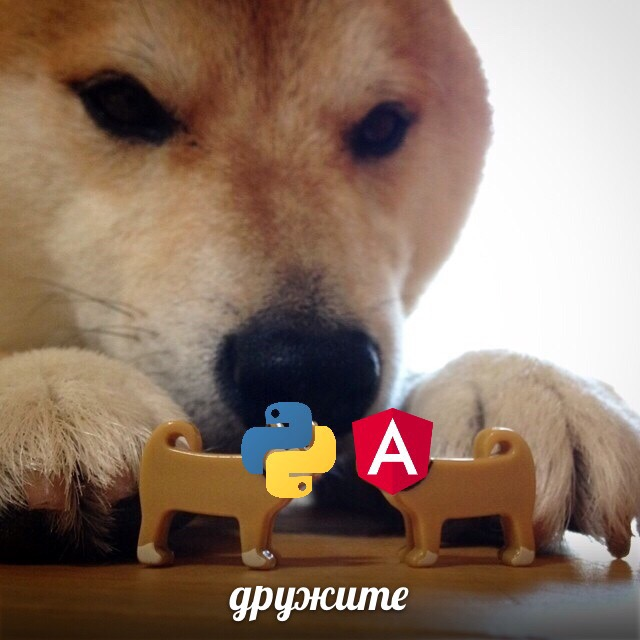

In [26]:
Image(filename='pic.jpg', width=500)

In [27]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from flask import Flask, request, Response
from flask_cors import CORS, cross_origin
from flask import jsonify

model = pickle.load(open('model', 'rb'))
app = Flask(__name__)
CORS(app)

def parse_name(team):
    cv = CountVectorizer()
    cv_fit = cv.fit_transform(team)
    tmp = [cv.vocabulary_.get(name) for name in team]
    sup = 0
    for i in tmp:
        if i is not None:
            sup = i
    tmp = [i if i is not None else sup + 1200 for i in tmp]
    return sorted(tmp)

@app.route('/', methods=['POST'])
def predict():
    data = request.json
    home_team = data['leftTeam']
    away_team = data['rightTeam']
    home_team = parse_name(home_team)
    away_team = parse_name(away_team)
    home_goals = data['leftCountryScore']
    away_goals = data['rightCountryScore']
    feature = home_team + away_team + [home_goals, away_goals]
    result = model.predict([feature])
    return jsonify({'result': str(int(*result))})

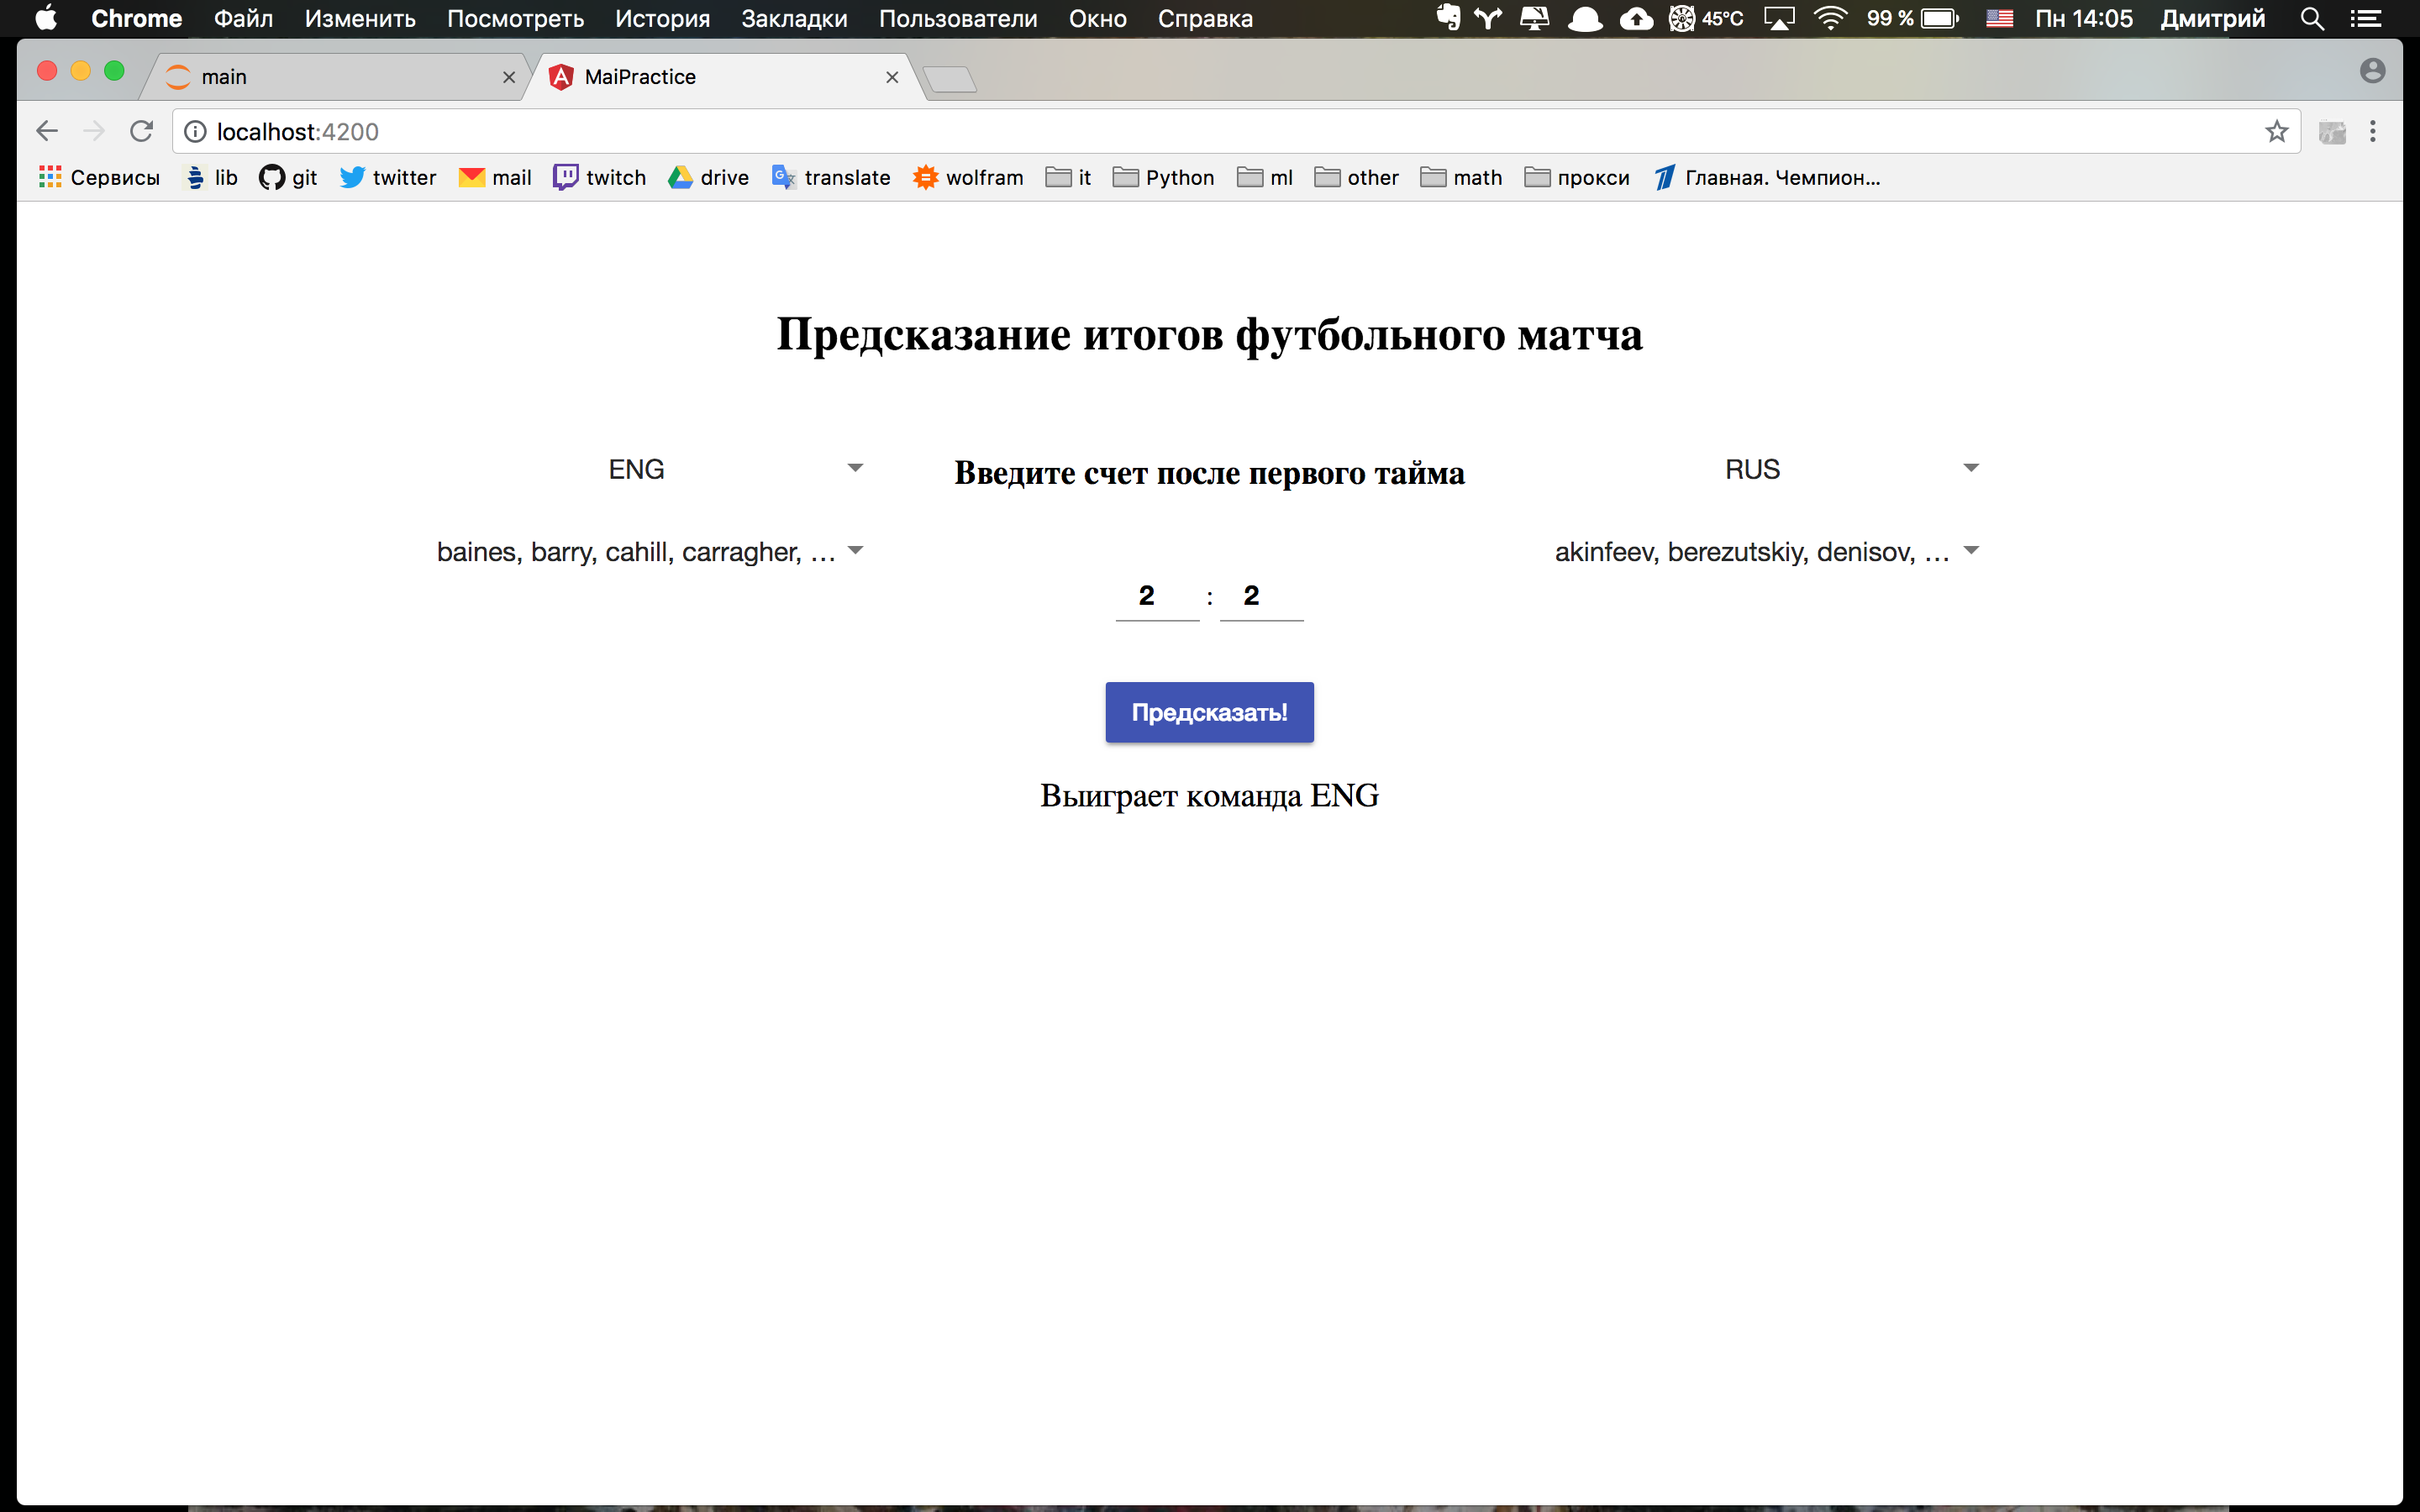

In [28]:
Image(filename='pic2.png', width=600)